Question 01

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv 

Parameters of the largest circle:
Center: (110, 258)
Radius: 15
Sigma value: 2.0


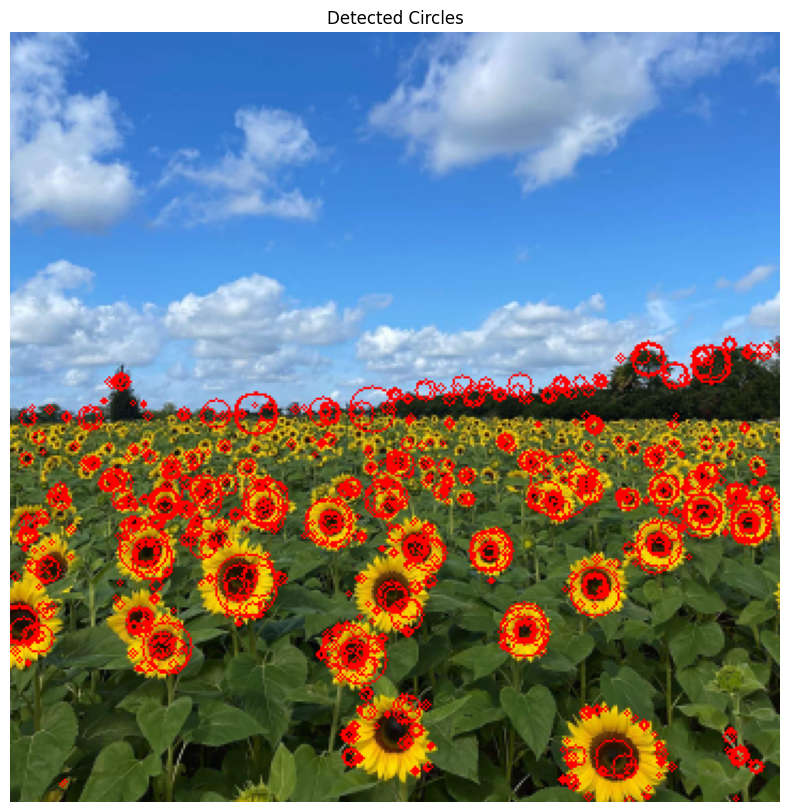

In [136]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the sunflower field image
image = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Set up parameters for scale-space extrema detection
min_sigma = 1.0  # Minimum sigma value (smaller values for smaller blobs)
max_sigma = 2.0  # Maximum sigma value (larger values for larger blobs)
num_sigma = 5 # Number of sigma values to test
threshold = 0.35  # Threshold for blob detection

# Create an empty list to store detected circles
circles = []

# Loop through different sigma values to detect blobs at different scales
for sigma in np.linspace(min_sigma, max_sigma, num_sigma):
    # Apply LoG (Laplacian of Gaussian) to the grayscale image with the current sigma
    blurred = cv2.GaussianBlur(gray_image, (0, 0), sigma)
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)

    # Calculate the absolute Laplacian values
    abs_laplacian = np.abs(laplacian)

    # Create a binary image where blobs are detected using the threshold
    blob_mask = abs_laplacian > threshold * abs_laplacian.max()

    # Find contours in the blob mask
    contours, _ = cv2.findContours(blob_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through the detected contours and fit circles to them
    for contour in contours:
        if len(contour) >= 5:
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            circles.append((center, radius, sigma))

# Sort the detected circles by radius in descending order
circles.sort(key=lambda x: -x[1])

# Report the parameters of the largest circle
largest_circle = circles[0]
center, radius, sigma = largest_circle

print("Parameters of the largest circle:")
print(f"Center: {center}")
print(f"Radius: {radius}")
print(f"Sigma value: {sigma}")

# Set the desired line thickness for drawn circles
line_thickness = 1

# Draw all detected circles with the specified line thickness
output_image = image.copy()
for circle in circles:
    center, radius, _ = circle
    cv2.circle(output_image, center, radius, (0, 0, 255), line_thickness)  # Red color

# Display the grayscale image with detected circles using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Detected Circles')
plt.show()

Question 02

In this question, we will fit a line and, subsequently, a circle to a set of noisy points that conform to a line
and a circle. The code snippet in Listing 1 shows the code to generate this noisy point set X amounting to a
circle and a line. We can characterize a line with three parameters a,b,d where [a,b]
⊺
is the unit normal to
the line adn d is the perpendicular distance from the origin (see the slide on total least squares line fitting).
We can parameterize a circle using the center [x, y]
⊺ and the radius r. Given a set of inliers (points that we
know belong to a model, e.g., a circle) we can estimate the best fitting model (best circle) using an optimizer
like scipy.minimize (see the documentation). To learn a little of the problem setting in optimization, read
the section 1.1 of Boyd and Vandenberghe. We find the inliers within the framework of RANSAC. Consider
the noisy pointset X.

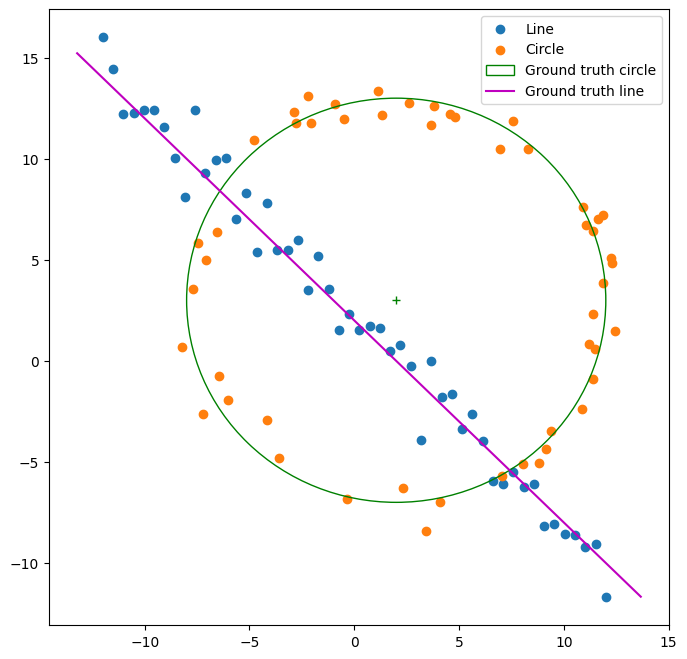

In [28]:
# Generation of a Noisy Point Set Conforming to a Line and a Circle
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib

# np.random.seed(0)
N=100
half_n=N//2
r = 10

x0_gt,y0_gt = 2,3 # Center
s = r/16
t = np.random.uniform (0,2*np.pi,half_n)
n = s*np.random.randn(half_n)
x,y = x0_gt + (r+n)*np.cos(t), y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack ((x.reshape(half_n,1), y.reshape(half_n,1)))

s = 1.
m, b = -1, 2
x = np.linspace (-12, 12 , half_n )
y = m*x + b + s*np.random.randn ( half_n )
X_line = np.hstack((x.reshape(half_n, 1), y.reshape (half_n, 1)))
X = np.vstack((X_circ,X_line)) # All points

fig,ax = plt.subplots (1,1,figsize=(8,8))
ax.scatter(X_line[:,0], X_line[:,1],label= 'Line')
ax.scatter(X_circ[:,0],X_circ[:,1],label='Circle')
circle_gt=plt.Circle((x0_gt,y0_gt),r,color='g',fill=False,label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt),(y0_gt),'+',color='g')
x_min,x_max = ax.get_xlim()
x_ = np.array([x_min,x_max])
y_ = m*x_ + b
plt.plot(x_,y_,color= 'm',label='Ground truth line')
plt.legend()




Part (a)

Estimate the line using the RNASAC algorithm (must be coded on your own). Ensure that you apply
the constraint ∥[a,b]⊺∥ = 1. Carefuly select the error (the normal distance to the estimated line) and
the number of points that must be in the consensus.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.681018137359508e-11
            Iterations: 9
            Function evaluations: 40
            Gradient evaluations: 9
rex.x:  [ 0.54475732  0.83859374 -1.7024884 ]
Iteration =  0 . No. inliners =  10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.376222392698389e-11
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [ 0.58408103  0.81169554 -0.96056759]
Iteration =  1 . No. inliners =  11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.867479768605229e-08
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [0.66615094 0.74581701 1.79297877]
Iteration =  2 . No. inliners =  31
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.507751727708548
            Iter

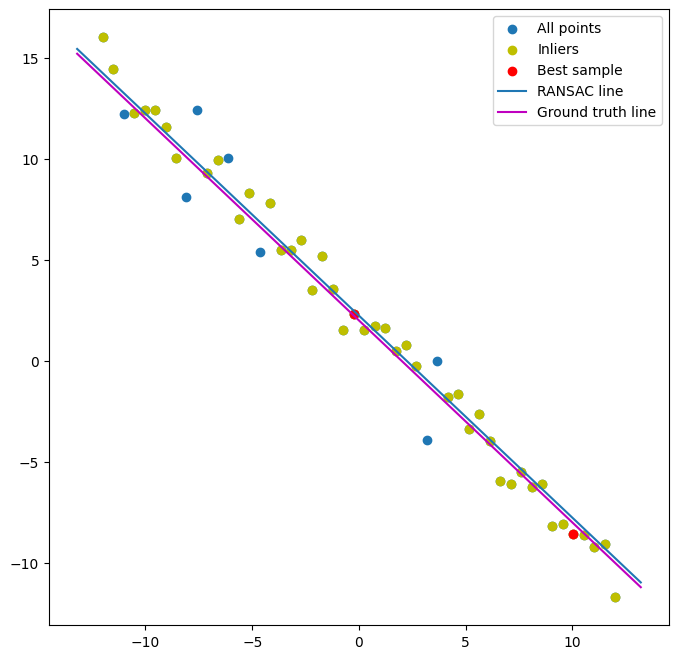

In [29]:
# Item 2: Total least squares line fitting with scicpy.optimize with RANSAC
import math
N = X_line.shape[0]
X_ = X_line

def line_equation_from_points(x1, y1, x2, y2):
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    # Return the line equation in the form ax + by = d
    return a, b, d

# RANSAC to fit a line
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))
# Constraint
def g(x):
    return x[0]**2 + x[1]**2 - 1
cons = ({'type': 'eq', 'fun': g})
# Computing the consensus (inliers)
def consensus_line(X, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t
t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.
inliers_line = []        # Indinces of the inliers
max_iterations = 50
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(X_, res.x, t) # Computing the inliers
    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum())
    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        print(res.x, res.fun)
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0],X_line[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()


Part (b)

Subtract the consensus of the best line (remnant) and estimate the circle that fits the remnant using
RANSAC. Carefully select the threshold of error (radial error) and the number of points that must be
in the consensus.

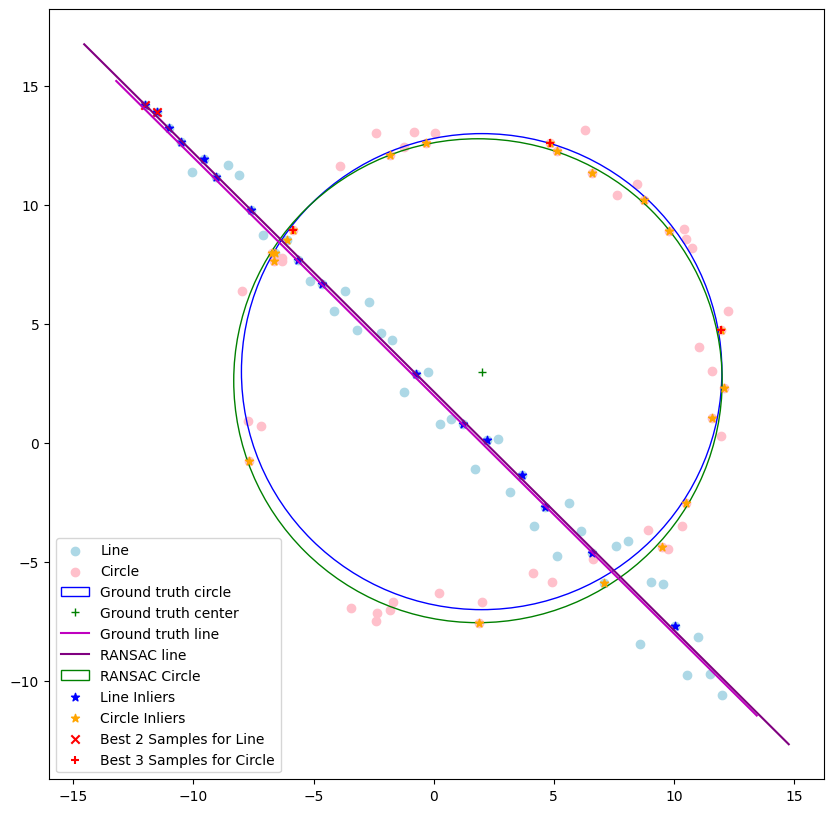

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(1)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

# Generate points for the circle
theta = np.random.uniform(0, 2 * np.pi, half_n)
noise = s * np.random.randn(half_n)
x_circle = x0_gt + (r + noise) * np.cos(theta)
y_circle = y0_gt + (r + noise) * np.sin(theta)

X_circ = np.column_stack((x_circle, y_circle))

# Generate points for the line
s = 1.0
m, b = -1, 2

x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s * np.random.randn(half_n)

X_line = np.column_stack((x_line, y_line))

# Concatenate points from both circle and line to create X
X = np.vstack((X_circ, X_line))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(X_line[:, 0], X_line[:, 1], color = 'lightblue', label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color = 'pink', label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='blue', fill=False, label='Ground truth circle')
ax.add_artist(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = m * x_range + b
plt.plot(x_range, y_range, color='m', label='Ground truth line')


# Define a function to calculate the line equation from two points
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line with unit normal constraint
def ransac_line(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 2, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        
        a, b, d = line_equation_from_points(x1, y1, x2, y2)
        
        # Constraint: Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        # Calculate the distance of all points to the line
        distances = np.abs(a*X[:,0] + b*X[:,1] - d)
        
        # Find inliers based on the threshold
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (a, b, d)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters
iterations = 10000
threshold = 0.15
min_inliers = 15

# Estimate the line using RANSAC
best_line_model, Line_inlier_indices = ransac_line(X_line, iterations, threshold, min_inliers)

# Define a function to calculate the circle equation from three points
def circle_equation_from_points(x1, y1, x2, y2, x3, y3):
    # Calculate the midpoints of two line segments
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x2 + x3) / 2, (y2 + y3) / 2
    # Calculate the slopes of the two lines
    if y2 - y1 == 0:
        slope1 = 0  # Avoid division by zero
    else:
        slope1 = (x2 - x1) / (y2 - y1)
    
    if y3 - y2 == 0:
        slope2 = 0  # Avoid division by zero
    else:
        slope2 = (x3 - x2) / (y3 - y2)
    
    # Calculate the center of the circle
    x_center = (slope1 * mx1 - slope2 * mx2 + my2 - my1) / (slope1 - slope2)
    y_center = -slope1 * (x_center - mx1) + my1
    
    # Calculate the radius
    radius = np.sqrt((x1 - x_center)**2 + (y1 - y_center)**2)
    
    return x_center, y_center, radius

# RANSAC to fit a circle
def ransac_circle(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 3, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        x3, y3 = X[sample_indices[2]]        
        x_center, y_center, radius = circle_equation_from_points(x1, y1, x2, y2, x3, y3)        
        # Calculate the radial error of all points to the circle
        errors = np.abs(np.sqrt((X[:, 0] - x_center)**2 + (X[:, 1] - y_center)**2) - radius)        
        # Find inliers based on the threshold
        inliers = np.where(errors < threshold)[0]        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (x_center, y_center, radius)
                best_inliers = inliers                
    return best_model, best_inliers

# RANSAC parameters for circle estimation
circle_iterations = 1000
circle_threshold = 0.3  # Adjust the threshold as needed
circle_min_inliers = 10

# Identify the remnant points (not explained by the line)
remnant_indices = [i for i in range(len(X)) if i not in Line_inlier_indices]
remnant_points = X[remnant_indices]
# Estimate the circle using RANSAC
best_circle_model, circle_inlier_indices = ransac_circle(remnant_points, circle_iterations, circle_threshold, circle_min_inliers)


# Plot the results

# Plot the estimated line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[0] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC line', color='purple')
# Plot the estimated circle
x_center, y_center, radius = best_circle_model
circle_estimated = plt.Circle((x_center, y_center), radius, color='g', fill=False, label='RANSAC Circle')
ax.add_artist(circle_estimated)

ax.scatter(X_line[Line_inlier_indices, 0], X_line[Line_inlier_indices, 1], color='blue',marker='*', label='Line Inliers')


# Find the best 2 samples for the line
best_line_sample_indices = Line_inlier_indices[:2]
best_line_samples = X_line[best_line_sample_indices]


# Plot the inliers of the circle
ax.scatter(remnant_points[circle_inlier_indices, 0], remnant_points[circle_inlier_indices, 1], color='orange',marker='*' ,label='Circle Inliers')



# Find the best 3 samples for the circle (using circle_inlier_indices)
best_circle_sample_indices = circle_inlier_indices[:3]
best_circle_samples = remnant_points[best_circle_sample_indices]


# Plot the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='+', label='Best 3 Samples for Circle')


plt.legend()
plt.show()
    

Question 03

Figure 2 shows an architectural image1 with a flag 2
superimposed. This is done by clicking four points on a
planar surface in the architectural image, computing a homography that maps the flag image to this plane,
and warping the flag, and blending on to the architectural image. Carry this out for a couple of image pairs
of you own choice. You may explain the (non-technical) rationale of your choice.

[[ 5.87358317e-01 -5.91796793e-03 -5.51905251e+02]
 [ 2.70864815e-02  5.41052469e-01 -3.13436639e+02]
 [ 1.31193946e-04  7.10624811e-07  1.00000000e+00]]


Text(0.5, 1.0, 'Image Warpped')

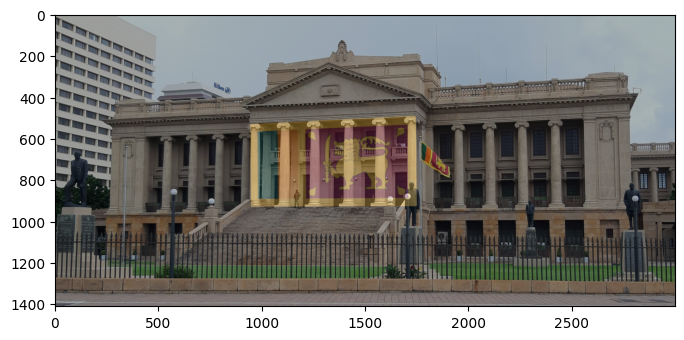

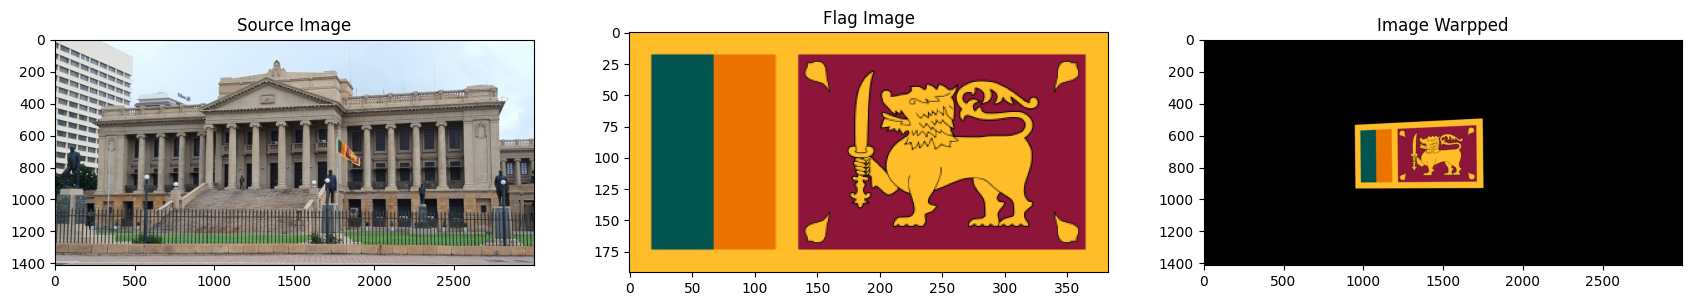

In [117]:
import cv2
import numpy as np

# Initialize list to store coordinates
coordinates = []

def select_points(event, x, y, flags, params):
    # If left mouse button clicked, record the starting coordinates
    if event == cv2.EVENT_LBUTTONDOWN:
        coordinates.append((x, y))

# Load the images
image1 = cv2.imread('parliament.jpg',cv.IMREAD_COLOR)
image2 = cv2.imread('Flag_of_Sri_Lanka.svg.png', cv.IMREAD_COLOR)

image1_copy=image1.copy()
image2_copy=image2.copy()

# Create a named window for the image
cv2.namedWindow('image1', cv2.WINDOW_NORMAL)

# Set mouse callback function to window
cv2.setMouseCallback('image1', select_points)

while(1):
    # Show the image
    cv2.imshow('image1', image1_copy)

    # Break loop when 'q' is pressed
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

# Compute homography
pts_src = np.array(coordinates)
pts_dst = np.array([[0, 0], [image2.shape[1] - 1, 0], [image2.shape[1] - 1, image2.shape[0] - 1], [0, image2.shape[0] - 1]])
h, status = cv2.findHomography(pts_src, pts_dst)
print(h)
# Warp source image to destination based on homography
img_warped = cv2.warpPerspective(image2, np.linalg.inv(h), (image1.shape[1],image1.shape[0]))
# Blend images
alpha = 0.7  # Define blending parameter (0 <= alpha <= 1)
blended = cv2.addWeighted(image1, alpha, img_warped, 1 - alpha, 0.0)

# Save blended image
cv2.imwrite('blended.jpg', blended)

fig, ax = plt.subplots(1,1,figsize= (8,8))
ax.imshow(cv.cvtColor(blended,cv.COLOR_BGR2RGB))

# Plotting the results
fig,ax=plt.subplots(1,3,figsize=(21,7))
ax[0].imshow(cv.cvtColor(image1,cv.COLOR_BGR2RGB))
ax[0].set_title("Source Image")
ax[1].imshow(cv.cvtColor(image2,cv.COLOR_BGR2RGB))
ax[1].set_title("Flag Image")
ax[2].imshow(cv.cvtColor(img_warped,cv.COLOR_BGR2RGB))
ax[2].set_title("Image Warpped")


[[ 5.51345570e-01 -4.09533128e-01  6.50958871e+01]
 [-2.47015323e-01  1.49091391e+00 -3.79556687e+02]
 [-4.56249177e-04 -2.68554675e-04  1.00000000e+00]]


Text(0.5, 1.0, 'Image Warpped')

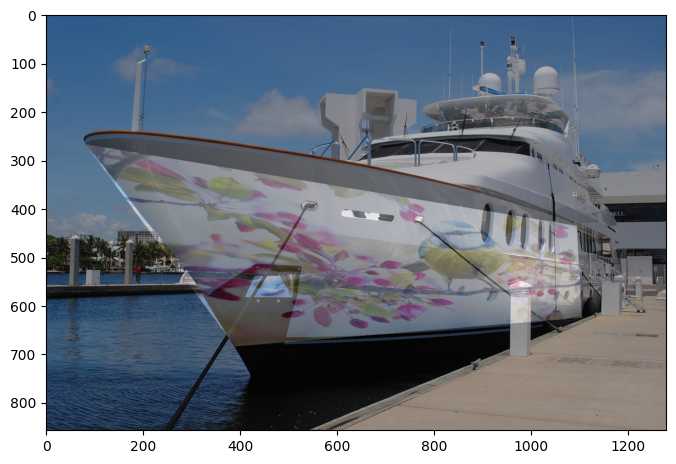

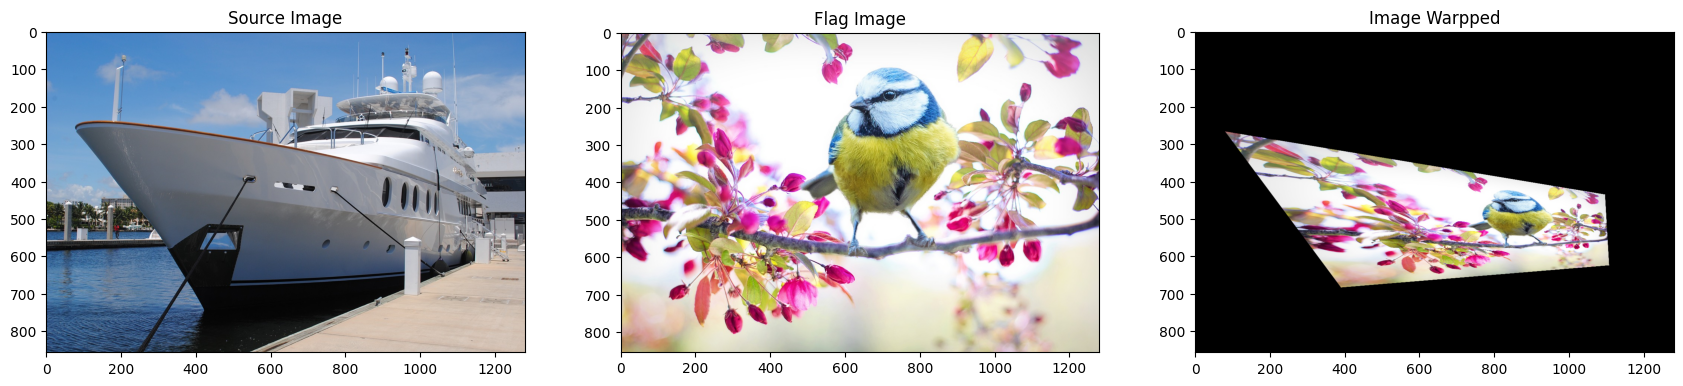

In [121]:
import cv2
import numpy as np

# Initialize list to store coordinates
coordinates = []

def select_points(event, x, y, flags, params):
    # If left mouse button clicked, record the starting coordinates
    if event == cv2.EVENT_LBUTTONDOWN:
        coordinates.append((x, y))

# Load the images
image1 = cv2.imread('yacht-1040850_1280.jpg',cv.IMREAD_COLOR)
image2 = cv2.imread('spring-bird-2295434_1280.jpg', cv.IMREAD_COLOR)

image1_copy=image1.copy()
image2_copy=image2.copy()

# Create a named window for the image
cv2.namedWindow('image1', cv2.WINDOW_NORMAL)

# Set mouse callback function to window
cv2.setMouseCallback('image1', select_points)

while(1):
    # Show the image
    cv2.imshow('image1', image1_copy)

    # Break loop when 'q' is pressed
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

# Compute homography1
pts_src = np.array(coordinates)
pts_dst = np.array([[0, 0], [image2.shape[1] - 1, 0], [image2.shape[1] - 1, image2.shape[0] - 1], [0, image2.shape[0] - 1]])
h, status = cv2.findHomography(pts_src, pts_dst)
print(h)

# Warp source image to destination based on homography
img_warped = cv2.warpPerspective(image2, np.linalg.inv(h), (image1.shape[1],image1.shape[0]))

# Blend images
alpha = 0.7  # Define blending parameter (0 <= alpha <= 1)
blended = cv2.addWeighted(image1, alpha, img_warped, 1 - alpha, 0.0)

# Save blended image
cv2.imwrite('blended.jpg', blended)

fig, ax = plt.subplots(1,1,figsize= (8,8))
ax.imshow(cv.cvtColor(blended,cv.COLOR_BGR2RGB))

# Plotting the results
fig,ax=plt.subplots(1,3,figsize=(21,7))
ax[0].imshow(cv.cvtColor(image1,cv.COLOR_BGR2RGB))
ax[0].set_title("Source Image")
ax[1].imshow(cv.cvtColor(image2,cv.COLOR_BGR2RGB))
ax[1].set_title("Flag Image")
ax[2].imshow(cv.cvtColor(img_warped,cv.COLOR_BGR2RGB))
ax[2].set_title("Image Warpped")


Question 04

In this questions, we will stitch the two Graffiti images img1.ppm onto img5.ppm.
1. Compute and match SIFT features between the two images.
2. Compute the homography using your own code within RANSAC and compare with the homography
given in the dataset.
3. Stitch img1.ppm onto img5.ppm.

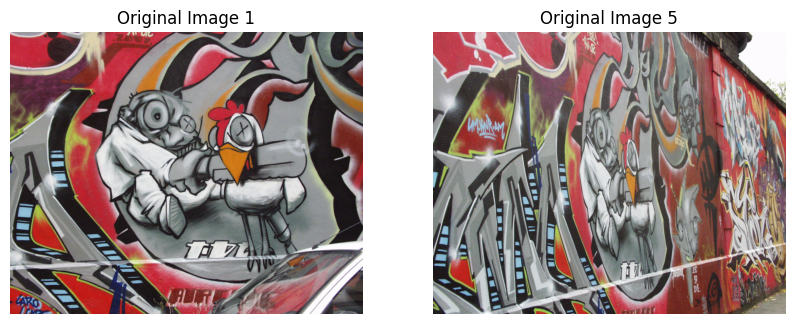

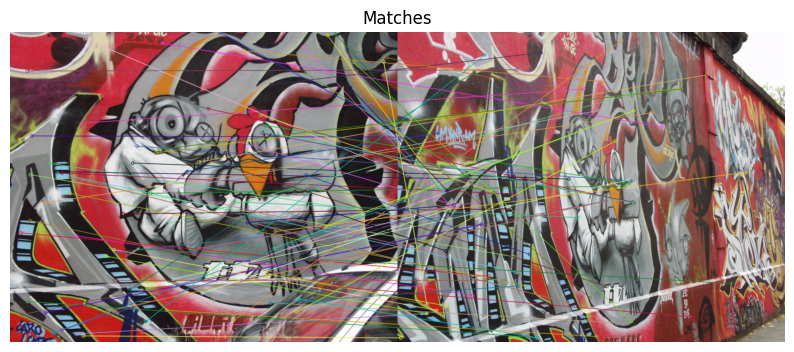

In [123]:
import cv2 as cv
import numpy as np

# Load the images
img1 = cv.imread('graf/img1.ppm')
img5 = cv.imread('graf/img5.ppm')

# Convert the images to grayscale
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1, 2, figsize = (10, 12))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('Original Image 1')
ax[1].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
ax[1].axis('off')
ax[1].set_title('Original Image 5')

plt.show()

# Initialize SIFT detector
sift = cv.SIFT_create()
# Find keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp5, des5 = sift.detectAndCompute(img5, None)
# # Initialize Brute-Force matcher and perform feature matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des5, k=2)
# Store all good matches as per Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append([m])
# Draw matches
img_matches = cv.drawMatchesKnn(img1, kp1, img5, kp5, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(img_matches, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Matches')
plt.show()

In [124]:
def get_homography(X, Y):
    O = np.array([
        [0],
        [0],
        [0]
    ])

    A = []

    for i in range(4):
        A.append(np.concatenate((O.T, np.expand_dims(X.T[i,:], axis=0), np.expand_dims(-1*Y[1, i]*X.T[i,:], axis=0) ), axis=1))
        A.append(np.concatenate((np.expand_dims(X.T[i,:], axis=0), O.T, np.expand_dims(-1*Y[0, i]*X.T[i,:], axis=0) ), axis=1))

    A = np.array(A).squeeze().astype(np.float64)

    eigen_values, eigen_vectors = np.linalg.eig(A.T @ A)
    H = eigen_vectors[:, np.argmin(eigen_values)]
    H = H.reshape(3, -1)

    return H

In [125]:
def get_inlier_count(X_full, Y_full, H, t, X_inliers, Y_inliers):
    count = 0

    t_X_full = H @ X_full
    t_X_full = t_X_full / t_X_full[2,:]

    error = np.sqrt(np.sum(np.square(t_X_full - Y_full), axis=0))

    inlier_indices = np.where(error <= t)[0]

    X_inliers = np.concatenate((X_inliers, X_full[:,inlier_indices]), axis=1)
    Y_inliers = np.concatenate((Y_inliers, Y_full[:,inlier_indices]), axis=1)

    count = inlier_indices.shape[0]

    return count, X_inliers, Y_inliers

In [126]:
def get_sift_features(img1_path, img2_path):
    img1 = cv.imread(img1_path)
    img5 = cv.imread(img2_path)

    img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

    sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = .1,edgeThreshold = 25,sigma =1)

    keypoints_1, descriptors_1 = sift.detectAndCompute(img1_gray, None) 
    keypoints_2, descriptors_2 = sift.detectAndCompute(img5_gray, None)  

    keypoints_img_1 = np.zeros(img1_gray.shape)
    keypoints_img_5 = np.zeros(img5_gray.shape)

    keypoints_img_1 = cv.drawKeypoints(img1_gray, keypoints_1, keypoints_img_1)
    keypoints_img_5 = cv.drawKeypoints(img5_gray, keypoints_2, keypoints_img_5)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)

    # Apply ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append([m])

    matches_img = np.zeros(img1_gray.shape)
    matches_img_fifty = np.zeros(img1_gray.shape)

    matches_img = cv.drawMatchesKnn(img1_gray, keypoints_1, img5_gray, keypoints_2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    good_matches = np.squeeze(np.array(good_matches))

    return good_matches, keypoints_1, keypoints_2

In [127]:
def RANSAC(img1_path, img2_path, t, d, N):
    # Parameter for the RANSAC algorithm 
    s = 4

    best_fit_homography = None
    best_inlier_count = 0
    best_fit_X_inliers = None
    best_fit_Y_inliers = None
    count_db = []

    matches, kp1, kp2 = get_sift_features(img1_path, img2_path)

    X_full = np.zeros((len(matches), 3))
    Y_full = np.zeros((len(matches), 3))

    for i, match in enumerate(matches):
        p1 = kp1[match.queryIdx].pt
        p2 = kp2[match.trainIdx].pt

        X_full[i,:] = np.array([p1[0], p1[1], 1])
        Y_full[i,:] = np.array([p2[0], p2[1], 1])
    
    X_full = X_full.T
    Y_full = Y_full.T

    for _ in range(N):
        x = []

        for i in range(s):
            hold_idx = np.random.randint(0, len(matches))
            
            if len(x) == 0:
                x.append(hold_idx)
            elif hold_idx == x[-1]:                
                while hold_idx == x[-1]:
                    hold_idx = np.random.randint(0, len(matches))
                
                x.append(hold_idx)
            else:
                x.append(hold_idx)
        
        X = np.zeros((4,3))
        Y = np.zeros((4,3))

        for i, idx in enumerate(x):
            match = matches[idx]

            p1 = kp1[match.queryIdx].pt
            p2 = kp2[match.trainIdx].pt

            X[i,:] = np.array([p1[0], p1[1], 1])
            Y[i,:] = np.array([p2[0], p2[1], 1])

        X = X.T
        Y = Y.T

        X_inliers = np.zeros((3, 1))
        Y_inliers = np.zeros((3, 1))
    
        H = get_homography(X, Y)        

        count, X_inliers, Y_inliers = get_inlier_count(X_full, Y_full, H, t, X_inliers, Y_inliers)

        X_inliers = np.delete(X_inliers, 0, axis=1)
        Y_inliers = np.delete(Y_inliers, 0, axis=1)

        count_db.append(count)

        if count > best_inlier_count:
            best_fit_homography = H
            best_inlier_count = count
            best_fit_X_inliers = X_inliers
            best_fit_Y_inliers = Y_inliers

    return best_fit_homography, best_inlier_count, count_db, best_fit_X_inliers, best_fit_Y_inliers


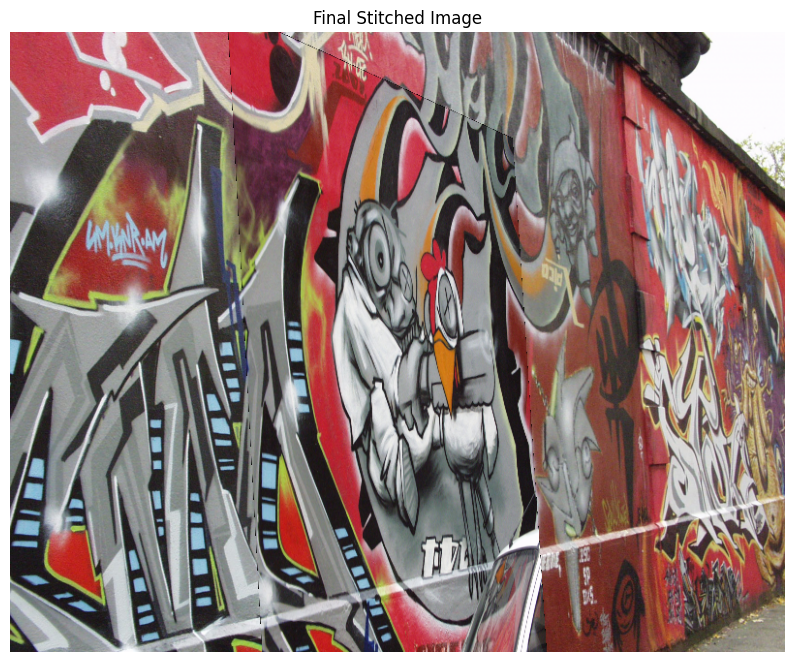

Text(0.5, 1.0, 'Final Stitched Image')

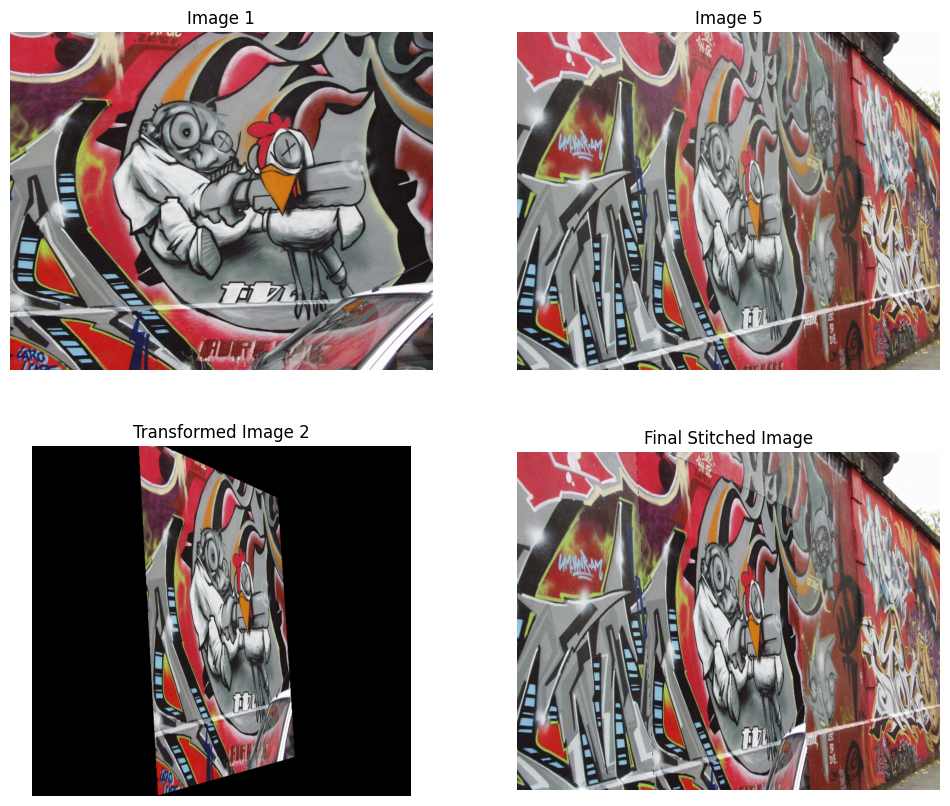

In [128]:
with open("graf/H1to5p", "r") as txt_file:
    actual_H = txt_file.read()
    actual_H = actual_H.split('\n')
    actual_H.pop()

    for i in range(len(actual_H)):
        actual_H[i] = list(map(float, actual_H[i].strip().split()))
    
    actual_H = np.array(actual_H)

path = r"graf/"
H_db = []

for i in range(1, 5):
    img1_path = path + "img" + str(i) + ".ppm"
    img2_path = path + "img" + str(i+1) + ".ppm"

    H, count, count_db, best_fit_X_inliers, best_fit_Y_inliers = RANSAC(img1_path, img2_path, 1, 20, 10000)

    H_db.append(H)

H1to5 = H_db[0]

for i in range(1, len(H_db)):
    H1to5 = H_db[i] @ H1to5

final_img = cv.imread("graf/img1.ppm")
final_img = cv.warpPerspective(final_img, H1to5, dsize=(img1.shape[1], img1.shape[0]+100))

t_img_1 = np.copy(final_img)

for i in range(final_img.shape[0]):
    for j in range(final_img.shape[1]):
        if np.all(final_img[i,j] == 0) and i < img5.shape[0] and j < img5.shape[1]:
            final_img[i,j] = img5[i,j]

# Crop final image to the size of image5
final_img = final_img[0:img5.shape[0], 0:img5.shape[1]]

# Plot final image
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(final_img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Final Stitched Image')
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0][0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0][1].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
ax[1][0].imshow(cv.cvtColor(t_img_1, cv.COLOR_BGR2RGB))
ax[1][1].imshow(cv.cvtColor(final_img, cv.COLOR_BGR2RGB))

ax[0][0].axis("off")
ax[0][1].axis("off")
ax[1][0].axis("off")
ax[1][1].axis("off")

ax[0][0].set_title("Image 1")
ax[0][1].set_title("Image 5")
ax[1][0].set_title("Transformed Image 2")
ax[1][1].set_title("Final Stitched Image")